In [1]:
import torch
import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor
import tarfile
from io import BytesIO
import numpy as np
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm 
import os
import matplotlib.pyplot as plt
from scipy.special import gamma, hyp2f1, betainc
from scipy.spatial.distance import cosine
import math

## High‑Dimensional Spaces Have Huge Capacity

$$capacity = \binom{n}{\lfloor d \cdot n \rfloor}
\cdot 2^{\lfloor d \cdot n \rfloor}$$

In [10]:
def calculate_capacity(n_values, d):
    capacities = []

    for n in n_values:
        floor_dn = math.floor(d * n)
        binomial_coefficient = math.comb(n, floor_dn)
        capacity = binomial_coefficient * 2**floor_dn
        capacities.append(capacity)

    return np.array(capacities)

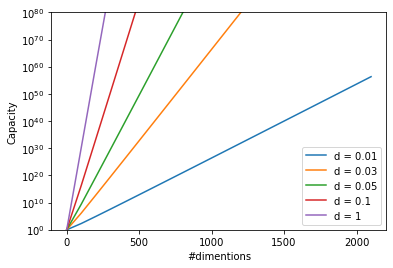

In [12]:
n_dimensions = np.arange(0, 2200, 100)
d_values = [0.01, 0.03, 0.05, 0.1, 1]


for d in d_values:
    capacities = calculate_capacity(n_dimensions, d)
    y_limit = 1e90
    plt.plot(n_dimensions, np.minimum(capacities, y_limit), label=f'd = {d}')


plt.yscale('log')
plt.ylim(1, 1e80)
plt.xlabel('#dimentions')
plt.ylabel('Capacity')
plt.legend()
plt.show()

## Nearest Neighbor Becomes Unstable or Meaningless

$\text{Sampling Density} \propto k^{1/n}$


$k \propto \text{Sampling Density}^n$

k : number of samples

n : number of dimensions

#### Neighbor Becomes Meaningless

Given a set of data points in an n-dimensional metric space, the task is to find the closest data point to some query point.

For a fixed $ \epsilon $, a query is considered unstable if its distance to most point is less than $ 1 + \epsilon $ the distance to the nearest point.

For every $ \epsilon $ the probability of a query being unstable approaches 1 as n increases.



In [181]:
k = 100
n_queries = 100
epsilon = 0.1

prob_unstable_query = []

def l2_distance(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)

for n in range(1, 51):
    dataset = np.random.normal(size=(k, n)) #np.random.rand(n_samples + 1, n)
    n_unstable_queries = 0
    for i in range(n_queries):
      reference_vector = np.random.normal(n)
      distances = [l2_distance(reference_vector, row) for row in dataset]

      min_distance = min(distances)


      very_close = -1
      for distance in distances:
        if distance <= (1 + epsilon)*min_distance:
          very_close+=1

      if very_close/len(distances) >= 0.98:
        n_unstable_queries+=1

    prob_unstable_query.append(n_unstable_queries/n_queries)

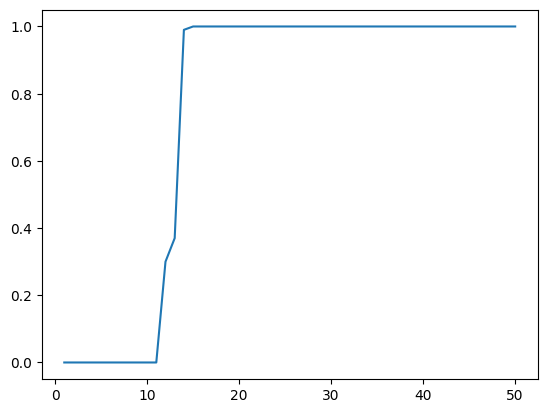

In [182]:
plt.plot(range(1, 51), prob_unstable_query)
plt.show()

## Random Vectors are Very Likely Almost Orthogonal

$A_n(r)=\frac{2 \pi^{n / 2}}{\Gamma\left(\frac{n}{2}\right)} r^{n-1}$

$A_n(\Phi, r)=r^{n-1} \frac{\pi^{n / 2}}{\Gamma(n / 2)} I_{\sin ^2 \Phi}\left(\frac{n-1}{2}, \frac{1}{2}\right)$

$ I_{\sin ^2 \Phi} $: regularized incomplete beta function

$ \Gamma $: gamma function

$ r $: radius of the n-sphere

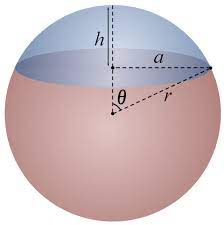

In [2]:
def cap_surface_area(radius, n_dimensions, angle_phi):
    """
    Calculate the surface area of a hyperspherical cap in n-dimensional space.

    Parameters:
    - radius: Radius of the hypersphere.
    - n_dimensions: Number of dimensions.
    - angle_phi: Angle of the cap in radians.

    Returns:
    - Surface area of the cap.
    """
    prefactor = radius**(n_dimensions - 1) * np.pi**(n_dimensions / 2) / gamma(n_dimensions / 2)

    surface_area = prefactor * betainc((n_dimensions - 1) / 2, 1 / 2, np.sin(angle_phi)**2)

    return surface_area


def hypersphere_surface_area(dimensions):
    surface_area = 2 * (math.pi ** (dimensions / 2)) / gamma(dimensions / 2 )
    return surface_area

radius = 1.0
epsilon = 0.1


similar_area = $A_n(\epsilon, 1)$

orthogonal_area = $A_n(1) - 2 \cdot A_n(\frac{\pi}{2} - \epsilon, 1)$

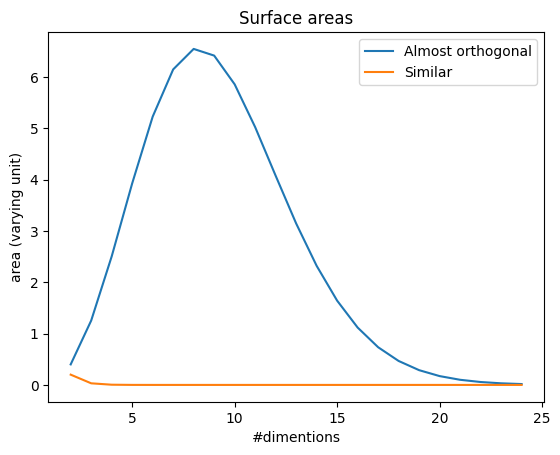

In [3]:
n_dimensions = np.arange(2,25)

similar_areas = cap_surface_area(radius, n_dimensions, epsilon)
orthogonal_areas = hypersphere_surface_area(n_dimensions) - 2*cap_surface_area(radius, n_dimensions, math.pi/2 - epsilon) #hypersphere_surface_area(n_dimensions-1) * 2 * np.sin(epsilon)

plt.plot(n_dimensions, orthogonal_areas, label="Almost orthogonal")
plt.plot(n_dimensions, similar_areas, label="Similar")
plt.ylabel("area (varying unit)")
plt.xlabel("#dimentions")
plt.legend()
plt.title("Surface areas")
plt.show()

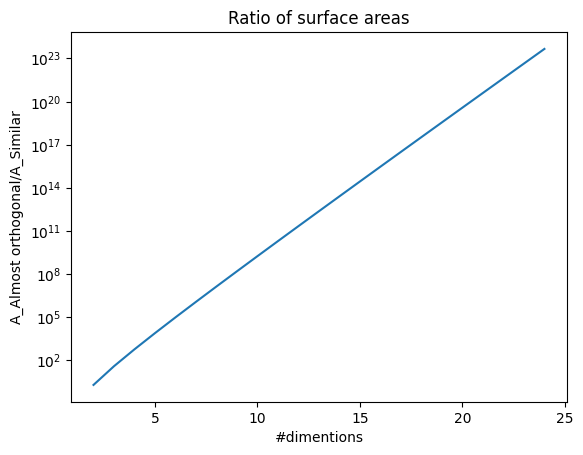

In [4]:
plt.plot(n_dimensions, orthogonal_areas/similar_areas)

plt.yscale('log')
plt.ylabel("A_Almost orthogonal/A_Similar")
plt.xlabel("#dimentions")
plt.title("Ratio of surface areas")
plt.show()

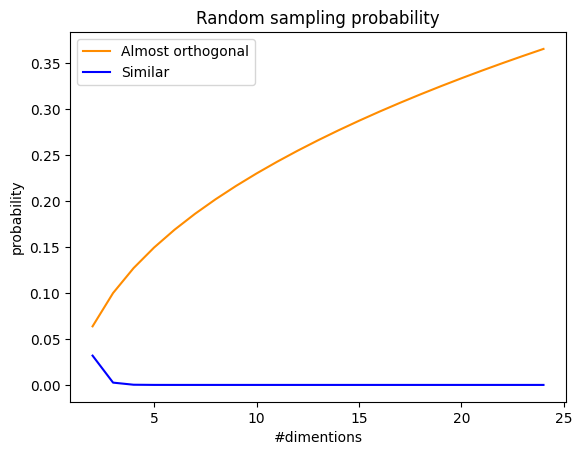

In [5]:
total_areas = hypersphere_surface_area(n_dimensions)

plt.plot(n_dimensions, orthogonal_areas/total_areas, label="Almost orthogonal", color = "darkorange")
plt.plot(n_dimensions, similar_areas/total_areas, label="Similar", color = "blue")
plt.ylabel("probability")
plt.xlabel("#dimentions")
plt.legend()
plt.title("Random sampling probability")
plt.show()

In [6]:
n_dimensions = np.arange(2,300)
similar_areas = cap_surface_area(radius, n_dimensions, epsilon)
orthogonal_areas = hypersphere_surface_area(n_dimensions) - 2*cap_surface_area(radius, n_dimensions, math.pi/2 - epsilon) #hypersphere_surface_area(n_dimensions-1) * 2 * np.sin(epsilon)
total_areas = hypersphere_surface_area(n_dimensions)

prob_orthogonal = orthogonal_areas/total_areas
prob_similar = similar_areas/total_areas



In [7]:
n_samples = 1000

exp_prob_orthogonal = []
exp_prob_similar = []

for n in range(301, 1001):
    random_matrix = np.random.normal(size=(n_samples + 1, n)) #np.random.rand(n_samples + 1, n)
    reference_vector = random_matrix[0, :]
    cosine_similarities = [1 - cosine(reference_vector, row) for row in random_matrix[1:, :]]
    angles_radians = np.arccos(cosine_similarities)
    orth = 0
    sim = 0
    for angle in angles_radians:
        if angle >= math.pi/2 - epsilon and angle <= math.pi/2 + epsilon:
            orth+=1
        if angle <= epsilon and angle >= -epsilon:
            sim+=1
    exp_prob_orthogonal.append(orth/n_samples)
    exp_prob_similar.append(sim/n_samples)


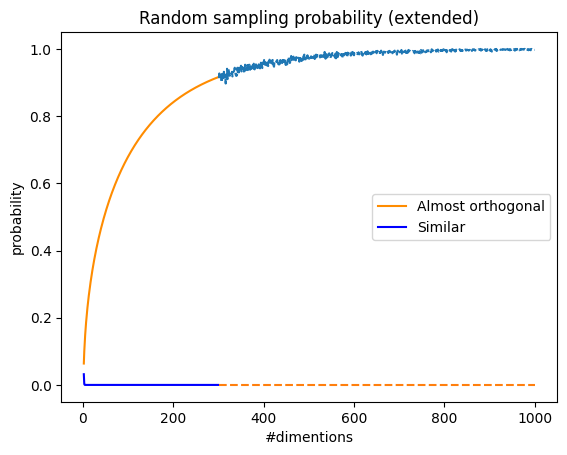

In [8]:
plt.plot(n_dimensions, prob_orthogonal, label="Almost orthogonal", color = "darkorange")
plt.plot(n_dimensions, prob_similar, label="Similar", color = "blue")

plt.plot(range(301, 1001), exp_prob_orthogonal, '--')
plt.plot(range(301, 1001), exp_prob_similar, '--')

plt.ylabel("probability")
plt.xlabel("#dimentions")
plt.legend()
plt.title("Random sampling probability (extended)")
plt.show()

##### Auxiliary functions

In [2]:
def generate_random_vectors(num_vectors, dimension):
    return np.random.rand(num_vectors, dimension)

def generate_random_vectors11(num_vectors, dimension):
    return (2 * np.random.random((num_vectors, dimension))) - 1

def add_noise(vector, mean=0, std=0.5):
    noise = np.random.normal(mean, std, vector.shape)
    return vector + noise

def calculate_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

The blue example database vector [1/2, ... , 1/2] is affected by additive noise $\mathcal{N}(0, 0.5)$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


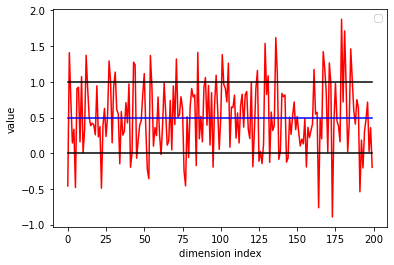

In [3]:
dims = range(200)
vect = np.array([1/2]*200)
noise_vect = add_noise(vect)
plt.plot(dims, noise_vect, color='red')
plt.plot(dims, vect, color='blue')
plt.plot(dims, np.zeros(200), color='black')
plt.plot(dims, np.ones(200), color='black')
plt.xlabel('dimension index')
plt.ylabel('value')
plt.legend()

Robustness towards diferent noise

In [15]:
max_dimension = 200
num_vectors = 1000

probabilities = np.zeros((int(max_dimension/5), 3))
dim = []
k = 0
for dimension in tqdm(range(0, max_dimension, 5)):
    vectors = generate_random_vectors(num_vectors, dimension)

    l = []
    for std in [0.1, 0.25, 0.5]:
        count_correct = 0
        
        for i in range(1000):
            indices_to_add = np.random.choice(num_vectors, size=1, replace=False)
            selected_vectors = [vectors[i] for i in indices_to_add]

            sum_vectors = add_noise(np.sum(selected_vectors, axis=0), mean=0, std=std)

            similarities = [calculate_similarity(sum_vectors, vector) for vector in vectors]

            top_indices = np.argsort(similarities)[-1:]

            if set(indices_to_add) == set(top_indices):
                count_correct += 1
        l.append(1 - count_correct/1000)
            
    probabilities[k] = np.array(l)
    dim.append(dimension)
    k += 1

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_15764\3447095169.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [04:29<00:00,  6.74s/it]


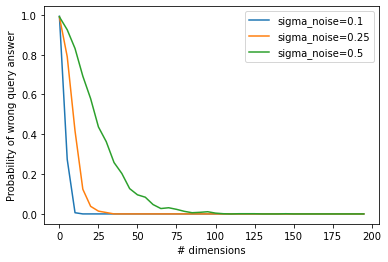

In [16]:
i = 0
for std in [0.1, 0.25, 0.5]:
    plt.plot(dim, probabilities[:,i], label = f"sigma_noise={std}")
    i += 1
plt.xlabel('# dimensions')
plt.ylabel('Probability of wrong query answer')
plt.legend()

##### Noise has Low Infuence on Nearest Neighbor Queries with Random Vectors

Random vectors from $\mathcal{V} = [0,1]^n$

In [6]:

max_dimension = 1000
num_vectors = 1000

probabilities = np.zeros((int(max_dimension/10), 4))
dim = []
k = 0
for dimension in range(0, max_dimension, 10):
    vectors = generate_random_vectors(num_vectors, dimension)

    l = []
    for j in range(2,6):
        count_correct = 0

        for i in range(1000):
            indices_to_add = np.random.choice(num_vectors, size=j, replace=False)

            selected_vectors = [vectors[i] for i in indices_to_add]

            sum_vectors = np.sum(selected_vectors, axis=0)

            similarities = [calculate_similarity(sum_vectors, vector) for vector in vectors]

            top_indices = np.argsort(similarities)[-j:]

            if set(indices_to_add) == set(top_indices):
                count_correct += 1

                
        l.append(1 - count_correct/1000)
            
    probabilities[k] = np.array(l)
    dim.append(dimension)
    k += 1
    



C:\Users\User\AppData\Local\Temp\ipykernel_15764\3447095169.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))


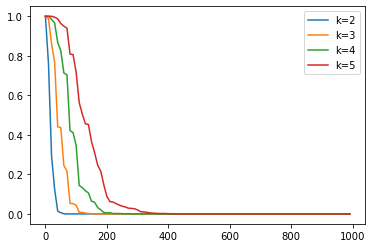

In [7]:
for i in range(2, 6):
    
    plt.plot(dim, probabilities[:,i-2], label = f"k={i}")
plt.legend()

Random vectors from $\mathcal{V} = [-1,1]^n$

In [8]:

max_dimension = 1000
num_vectors = 1000

probabilities = np.zeros((int(max_dimension/10), 9))
dim = []
k = 0
for dimension in tqdm(range(0, max_dimension, 10)):
    vectors = generate_random_vectors11(num_vectors, dimension)

    l = []
    for j in range(2,11):
        count_correct = 0

        for i in range(1000):
            indices_to_add = np.random.choice(num_vectors, size=j, replace=False)

            selected_vectors = [vectors[i] for i in indices_to_add]

            sum_vectors = np.sum(selected_vectors, axis=0)

            similarities = [calculate_similarity(sum_vectors, vector) for vector in vectors]

            top_indices = np.argsort(similarities)[-j:]

            if set(indices_to_add) == set(top_indices):
                count_correct += 1

        l.append(1 - count_correct/1000)
            
    probabilities[k] = np.array(l)
    dim.append(dimension)
    k += 1
    



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_15764\3447095169.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [37:34<00:00, 22.54s/it]


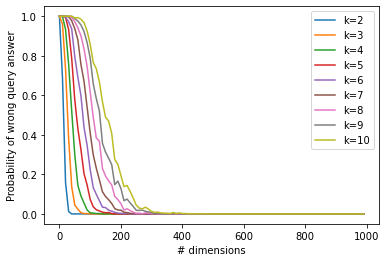

In [14]:
for i in range(2, 11):
    
    plt.plot(dim, probabilities[:,i-2], label = f"k={i}")
plt.xlabel('# dimensions')
plt.ylabel('Probability of wrong query answer')
plt.legend()

#### Application to robotic tasks

In [10]:
alexnet = models.alexnet(pretrained=True)
alexnet_cov3 = create_feature_extractor(alexnet,['features.6'])

c:\users\reda nassif\appdata\local\programs\python\python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\users\reda nassif\appdata\local\programs\python\python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
def generate_random_matrix(rows, cols):
    return np.random.normal(size=(rows, cols))

In [12]:
num_rows_R = 8192
num_col_R = 13*13*384
random_matrix_R = generate_random_matrix(num_rows_R,num_col_R)
random_matrix_R = torch.Tensor(random_matrix_R)
random_matrix_R /=torch.norm(random_matrix_R, p=2, dim=1, keepdim=True)

In [13]:
def encodeimg(angle_1,angle_2):
    dict_imgs = {}

    for i in range(1,60):
        image_file_name =[ f'png4/{i}/{i}_r{angle_1}.png',f'png4/{i}/{i}_r{angle_2}.png']
        output_shape = (224, 224)
        sommeI = 0 
        for j in range (2):
            image = Image.open(image_file_name[j])
            image_array = np.array(image)
            resized_image = Image.fromarray(image_array).resize(output_shape)
            resized_image_array = np.array(resized_image)
            img_tenser = torch.Tensor(resized_image_array.transpose(2,0,1))
            ecod_img = alexnet_cov3(img_tenser)['features.6'].flatten()
            ecod_img = ecod_img /torch.norm(ecod_img)
            encoded_img =torch.matmul( random_matrix_R , ecod_img )
            sommeI += encoded_img
        dict_imgs[i] = sommeI

    return dict_imgs

In [14]:
def encodeimg_topredict(angle_Predect):
    dict_imgs = {}
    for i in range(1,60):
        image_file_name = f'png4/{i}/{i}_r{angle_Predect}.png'
        output_shape = (224, 224)
        image = Image.open(image_file_name)
        image_array = np.array(image)
        resized_image = Image.fromarray(image_array).resize(output_shape)
        resized_image_array = np.array(resized_image)
        img_tenser = torch.Tensor(resized_image_array.transpose(2,0,1))
        ecod_img = alexnet_cov3(img_tenser)['features.6'].flatten()
        ecod_img = ecod_img /torch.norm(ecod_img)
        encoded_img =torch.matmul( random_matrix_R , ecod_img )
        dict_imgs[i]= encoded_img
    return dict_imgs

In [15]:
def cosine_distance(tensor1, tensor2):

    similarity = F.cosine_similarity(tensor1, tensor2, dim=0)

    distance = 1 - similarity
    return distance.item()

def find_nearest_neighbor(target_tensor, tensor_dictionary):
    min_distance = float('inf')
    nearest_neighbor_id = None

    for tensor_id, reference_tensor in tensor_dictionary.items():
        distance = cosine_distance(target_tensor, reference_tensor)

        if distance < min_distance:
            min_distance = distance
            nearest_neighbor_id = tensor_id

    return nearest_neighbor_id, min_distance

In [16]:
angles = [i*10 for i in range(1,19)]
list_acc = []
list_cosine = []
for angle in tqdm(angles): 
    all_I_100 = encodeimg(0,angle)
    to_pred_10 =  encodeimg_topredict(angle//2)
    l=0
    cosinebun = 0
    for i in range (1,60):
        nearest_neighbor_id, min_distance = find_nearest_neighbor(to_pred_10[i],all_I_100)
        
        cosinebun += min_distance

        if i == nearest_neighbor_id:
            l+=1
    list_acc.append(l/59)
    list_cosine.append(cosinebun/59)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [09:17<00:00, 30.97s/it]


In [17]:
def encodeimg_statics(angles):
    dict_imgs = {}

    for i in range(1,60):
        image_file_name =[ f'png4/{i}/{i}_r{angle}.png' for angle in angles]
        output_shape = (224, 224)
        sommeI = 0 
        for j in range (len(angles)):
            image = Image.open(image_file_name[j])
            image_array = np.array(image)
            resized_image = Image.fromarray(image_array).resize(output_shape)
            resized_image_array = np.array(resized_image)
            img_tenser = torch.Tensor(resized_image_array.transpose(2,0,1))
            ecod_img = alexnet_cov3(img_tenser)['features.6'].flatten()
            ecod_img = ecod_img /torch.norm(ecod_img)
            encoded_img =torch.matmul( random_matrix_R , ecod_img )
            sommeI += encoded_img
        dict_imgs[i] = sommeI

    return dict_imgs

In [18]:
anglesB4 = [0,90,180,270]
anglesB8 = [i*45 for i in range(8)]

In [19]:
angles = [i*10 for i in range(1,19)]
list_accB4 = []
list_accB8 = []
list_cosineB4 = []
list_cosineB8 = []
all_I_100_B4 = encodeimg_statics(anglesB4)
all_I_100_B8 = encodeimg_statics(anglesB8)
for angle in tqdm(angles): 

    to_pred_10 =  encodeimg_topredict(angle//2)
    l_4 = 0
    l_8 = 0
    min_distance_4s = 0
    min_distance_8s = 0
    for i in range (1,60):
        nearest_neighbor_id_4, min_distance_4 = find_nearest_neighbor(to_pred_10[i],all_I_100_B4)
        nearest_neighbor_id_8, min_distance_8 = find_nearest_neighbor(to_pred_10[i],all_I_100_B8)
        min_distance_4s += min_distance_4
        min_distance_8s += min_distance_4
        
        if i == nearest_neighbor_id_4:
            l_4+=1
        if i == nearest_neighbor_id_8:
            l_8+=1
            
    list_accB4.append(l_4/59)
    list_accB8.append(l_8/59)
    list_cosineB4.append(min_distance_4s/59)
    list_cosineB8.append(min_distance_8s/59)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [03:04<00:00, 10.23s/it]


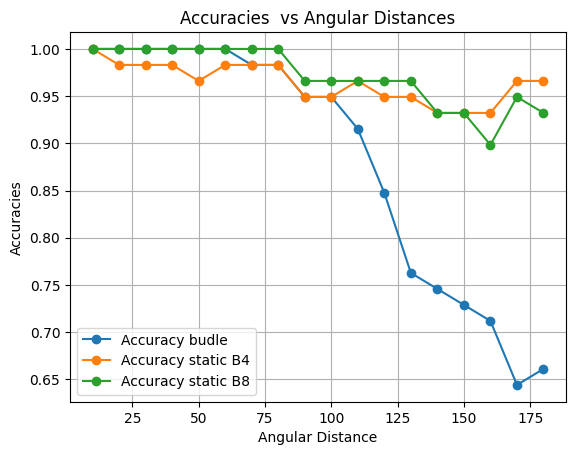

In [20]:
angular_distances = angles
plt.plot(angular_distances, list_acc, label='Accuracy budle', marker='o')
plt.plot(angular_distances, list_accB4, label='Accuracy static B4', marker='o')
plt.plot(angular_distances, list_accB8, label='Accuracy static B8', marker='o')
plt.title('Accuracies  vs Angular Distances')
plt.xlabel('Angular Distance')
plt.ylabel('Accuracies')
plt.legend()
plt.grid(True)
plt.show()


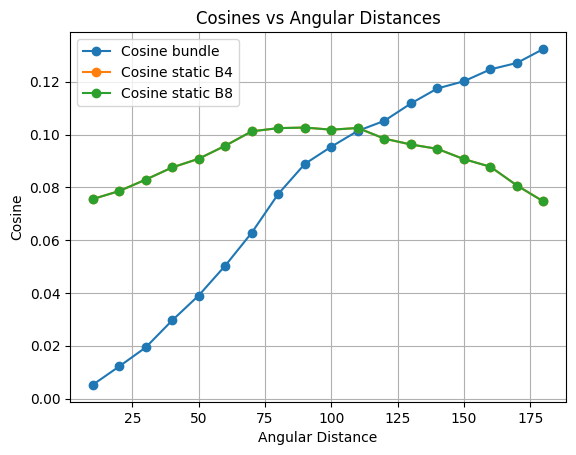

In [21]:
plt.plot(angular_distances, list_cosine, label='Cosine bundle', marker='o')
plt.plot(angular_distances, list_cosineB4, label='Cosine static B4', marker='o')
plt.plot(angular_distances, list_cosineB8, label='Cosine static B8', marker='o')
plt.title('Cosines vs Angular Distances')
plt.xlabel('Angular Distance')
plt.ylabel('Cosine')
plt.legend()
plt.grid(True)
plt.show()